#Project Summary
This project focus on forecasting electricity price using multiple models, including XGBoost, LSTM, and Temporal Fusion Transformer. the Goal of this project is to evaluate the accuracy, training efficiency and scalability for real-world forecasting application.

the dataset and features used in this project included electricity generation, load forecast, time and price data. Time features and lagged variable was selected and engineerd for better model performance.

#Installing Library

In [ ]:
%%capture
!pip install kaggle
!pip install statsmodels
!pip install scikit-learn
!pip install optuna
!pip install neuralforecast

##connect google drive for retrieve kaggle json

In [ ]:
from google.colab import files, drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
!rm /root/.kaggle
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/KaggleAPI/kaggle.json /root/.kaggle
#print(f"Done moving kaggle.json to /root/.kaggle")
!chmod 600 /root/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory


## Download Dataset from kaggle

In [ ]:
#title download dataset from kaggle dataset
#!/bin/bash
!kaggle datasets download nicholasjhana/energy-consumption-generation-prices-and-weather --force

Dataset URL: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
License(s): CC0-1.0
  0% 0.00/3.81M [00:00<?, ?B/s]
100% 3.81M/3.81M [00:00<00:00, 746MB/s]


In [ ]:
!unzip energy-consumption-generation-prices-and-weather.zip

Archive:  energy-consumption-generation-prices-and-weather.zip
  inflating: energy_dataset.csv      
  inflating: weather_features.csv    


##Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import optuna
from scipy.stats import skew, boxcox
#LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import time

#Preprocessing dataset

In [ ]:
df1 = pd.read_csv("energy_dataset.csv")

In [ ]:
energy_pd_clean=df1.copy()

In [ ]:
energy_pd_clean['time'] = pd.to_datetime(energy_pd_clean['time'], utc=True)
energy_pd_clean=energy_pd_clean.set_index('time')

In [ ]:
del_col= []
for x in energy_pd_clean:
  if energy_pd_clean[x].mean() == 0:
    del_col.append(x)
    energy_pd_clean = energy_pd_clean.drop(columns=[x])

print(del_col)

['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation marine', 'generation wind offshore']


In [ ]:
for x in energy_pd_clean:
  #check complete empty dataset
  if energy_pd_clean[x].isnull().sum() == len(energy_pd_clean):
    energy_pd_clean = energy_pd_clean.drop(columns=x)
  elif energy_pd_clean[x].isnull().sum() <= 100:
    energy_pd_clean = energy_pd_clean.fillna(energy_pd_clean[x].mean()) #fill na with mean value

In [ ]:
energy_pd_clean.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,3.506400e+04,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,3.506400e+04,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.513540,448.026074,5620.047948,4254.077779,298.365952,3.835135e+02,475.527457,971.797164,2603.974283,6261.056061,...,1432.127346,269.513939,5461.871471,1439.066735,3.835135e+02,5471.216689,28712.129962,28667.870679,49.874341,57.884023
std,85.330814,354.480583,2204.462047,1963.058313,52.543859,1.374493e-10,792.194787,400.903018,1835.418624,849.386642,...,1679.856688,50.252090,3214.927366,1677.703355,1.374493e-10,3176.312853,4594.100854,4661.679174,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.835135e+02,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.835135e+02,237.000000,18105.000000,383.513540,2.060000,9.330000
25%,333.000000,0.000000,4125.000000,2524.750000,263.000000,3.835135e+02,0.000000,637.000000,1076.000000,5757.000000,...,71.000000,240.000000,2930.750000,69.000000,3.835135e+02,2979.000000,24793.750000,24800.000000,41.490000,49.347500
50%,367.000000,509.000000,4968.000000,4473.000000,300.000000,3.835135e+02,68.000000,905.000000,2163.000000,6563.500000,...,615.000000,279.000000,4847.000000,576.000000,3.835135e+02,4855.000000,28906.000000,28894.000000,50.520000,58.020000
75%,433.000000,757.000000,6428.000000,5837.000000,330.000000,3.835135e+02,615.000000,1250.000000,3756.250000,7024.000000,...,2575.250000,310.000000,7397.000000,2636.000000,3.835135e+02,7353.000000,32263.250000,32186.250000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,3.835135e+02,4523.000000,2000.000000,9728.000000,7117.000000,...,5792.000000,383.513540,17436.000000,5836.000000,3.835135e+02,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [ ]:
#create lag time data
for lag in range(1,5):
  energy_pd_clean[f'price_actual_lag_{lag}'] = energy_pd_clean['price actual'].shift(lag)


In [ ]:
#drop 0 value after shifting time index
energy_pd_clean.dropna(subset=[f'price_actual_lag_{i}' for i in range(1,5)], inplace=True)

In [ ]:
#Smooth noise or capture trends
energy_pd_clean['rolling_mean_3'] = energy_pd_clean['price actual'].rolling(window=3).mean().shift(1)
energy_pd_clean['rolling_std_3'] = energy_pd_clean['price actual'].rolling(window=3).std().shift(1)

In [ ]:
energy_pd_clean.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind offshore eday ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'price_actual_lag_1', 'price_actual_lag_2', 'price_actual_lag_3',
       'price_actual_lag_4', 'rolling_mean_3', 'rolling_std_3'],
      dtype='object')

In [ ]:
energy_pd_clean['rolling_mean_3'].fillna(energy_pd_clean['rolling_mean_3'].mean(), inplace=True)
energy_pd_clean['rolling_std_3'].fillna(energy_pd_clean['rolling_std_3'].mean(), inplace=True)

/tmp/ipython-input-2440876934.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  energy_pd_clean['rolling_mean_3'].fillna(energy_pd_clean['rolling_mean_3'].mean(), inplace=True)
/tmp/ipython-input-2440876934.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

#Create Dataset for training

##Persistences benchmark

In [ ]:
#create persistence benchmark
start_time = time.time()
y_pred_persistence = energy_pd_clean['price_actual_lag_1']

#Evaluate performance on persistences benchmark
P_RMSE = np.sqrt(mean_squared_error(energy_pd_clean['price actual'], y_pred_persistence))
P_MSE = mean_squared_error(energy_pd_clean['price actual'], y_pred_persistence)
P_R2 = r2_score(energy_pd_clean['price actual'], y_pred_persistence)
end_time= time.time()
Pdelta_time = end_time - start_time
print(f"Time taken: {Pdelta_time:.2f} seconds")
print(f"Persistence RMSE: {P_RMSE:.3f}")
print(f"Persistence MSE: {P_MSE:.3f}")
print(f"Persistence MAE: {P_R2:.3f}")

Time taken: 0.01 seconds
Persistence RMSE: 3.661
Persistence MSE: 13.401
Persistence MAE: 0.934


##XGBRegressor model

In [ ]:
feature_cols = [col for col in energy_pd_clean.columns if 'lag' in col or 'rolling' in col or col in ['hour', 'year']]
X = energy_pd_clean[feature_cols]
y = energy_pd_clean['price actual']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
start_time = time.time()
XGBModel = XGBRegressor(
    n_estimators =100,
    max_depth =4,
    learning_rate = 0.1,
    random_state = 42
)

XGB_pred = XGBModel.fit(X_train, y_train).predict(X_test)
end_time = time.time()
XGdelta_time = end_time - start_time
print(f"Time taken: {XGdelta_time:.2f} seconds")

Time taken: 0.25 seconds


In [ ]:
#evaluation from XGB regresson
XGB_RMSE = np.sqrt(mean_squared_error(y_test, XGB_pred))
XGB_MAE = mean_absolute_error(y_test, XGB_pred)
XGB_R2 = r2_score(y_test, XGB_pred)

print(f"XGBoost RMSE: {XGB_RMSE:.3f}")
print(f"XGBoost MAE: {XGB_MAE:.3f}")
print(f"XGBoost R2: {XGB_R2:.3f}")

XGBoost RMSE: 2.604
XGBoost MAE: 1.819
XGBoost R2: 0.949


###Apply Optuna to fine tune

In [ ]:
def objective(trial):
    params={
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "objective": "reg:squarederror"
        }

    XGBmodel_opt = XGBRegressor(**params)
    XGBmodel_opt_pred =  XGBmodel_opt.fit(X_train, y_train, verbose=False).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,XGBmodel_opt_pred))
    return rmse


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-08-03 05:35:36,770] A new study created in memory with name: no-name-a87d4236-fc35-4315-b14a-da9431f69f17
[I 2025-08-03 05:35:39,482] Trial 0 finished with value: 2.599468098806073 and parameters: {'n_estimators': 613, 'max_depth': 6, 'learning_rate': 0.03569329255588572, 'subsample': 0.6858291148345812, 'colsample_bytree': 0.6586612986669577, 'min_child_weight': 9, 'reg_alpha': 0.15533268849468151, 'reg_lambda': 0.2167036348239222}. Best is trial 0 with value: 2.599468098806073.
[I 2025-08-03 05:35:44,802] Trial 1 finished with value: 2.95026983892 and parameters: {'n_estimators': 676, 'max_depth': 10, 'learning_rate': 0.2030515297598973, 'subsample': 0.9668731225082197, 'colsample_bytree': 0.7797606735388738, 'min_child_weight': 1, 'reg_alpha': 0.8011326767483753, 'reg_lambda': 0.5506563660022175}. Best is trial 0 with value: 2.599468098806073.
[I 2025-08-03 05:35:45,308] Trial 2 finished with value: 2.9682688005444775 and parameters: {'n_estimators': 434, 'max_depth': 3, 'le

Best RMSE: 2.5571135981161754
Best hyperparameters: {'n_estimators': 836, 'max_depth': 6, 'learning_rate': 0.01035006053950919, 'subsample': 0.6748287382538237, 'colsample_bytree': 0.9083557244573248, 'min_child_weight': 8, 'reg_alpha': 0.2868602418570228, 'reg_lambda': 0.444802808573428}


In [ ]:
optuna.visualization.plot_param_importances(study)

Based on the statistic of plot shows that learning rate has the highest impact on affecting the output of the model learning capabilites. Furthermore, n_estimator is the second impactful on influencing the model leanring capabilities. lastly, subsample is the third influence hyperparameter in affecting the model performances.

Other than that, due to having less than 0.1 hyperparameter importance. Thus, it concluded as least impact on influencing the model performances.

In [ ]:
optuna.visualization.plot_optimization_history(study)

Apply optimized hyperparameter on XGBRegressor

In [ ]:
start_time = time.time()
XGBModel2 = XGBRegressor(
    n_estimators =920,
    max_depth = 6,
    learning_rate = 0.01237,
    random_state = 42
)
XGB_pred_opt = XGBModel2.fit(X_train, y_train).predict(X_test)
end_time = time.time()
XGBdelt_time =  end_time -start_time
print(f"Time taken: {XGBdelt_time:.2f} seconds")

Time taken: 2.48 seconds


In [ ]:
#evaluation from XGB regresson
XGB2_RMSE = np.sqrt(mean_squared_error(y_test, XGB_pred_opt))
XGB2_MAE = mean_absolute_error(y_test, XGB_pred_opt)
XGB2_R2 = r2_score(y_test, XGB_pred)

print(f"Optimized XGBoost RMSE: {XGB2_RMSE:.3f}")
print(f"Optimized XGBoost MAE: {XGB2_MAE:.3f}")
print(f"Optimized XGBoost R2: {XGB2_R2:.3f}")

Optimized XGBoost RMSE: 2.566
Optimized XGBoost MAE: 1.803
Optimized XGBoost R2: 0.949


##Metrics comparison between persistence, XGBRegressor, Optimized Hyperparameter on XGBRegressor

In [ ]:
Evametrics = pd.DataFrame({
    'Model': ['Persistence', 'XGBRegressor', 'Optimized XGBRegressor'],
    'RMSE': [P_RMSE, XGB_RMSE, XGB2_RMSE],
    'MAE': [P_MSE, XGB_MAE, XGB2_MAE],
    'R2': [P_R2, XGB_R2, XGB2_R2]
})
Evametrics.set_index('Model', inplace=True)
Evametrics=Evametrics.style.set_caption("Model Evaluation Metrics").format("{:.5f}")
Evametrics

,RMSE,MAE,R2
Model,,,
Persistence,3.66068,13.40056,0.93358
XGBRegressor,2.60401,1.81935,0.94946
Optimized XGBRegressor,2.56624,1.80295,0.94946


Based from the observation shows that XGBRegressor and optimized XGBRegressor shows a clear improvement compare with persistence metrics. However, the optimization on hyperparameter has very less impact on improving XGBRegressor. Even with less learning rate, the model only able to reduce the RMSE and MAE from 2.605 to 2.561 and 1.824 to 1.802. But for R2 shows the identical value between pre and post optimization. Hence, the conclusion that can be make is model limitation on learning on the pattern of the dataset.

However, a 0.95 coefficient is consider high enough to conclude that the model is capable on predict the output accurately based on the provided features.

##LSTM model

In [ ]:
scaler = MinMaxScaler()
X1_train = scaler.fit_transform(X_train)
X1_test = scaler.fit_transform(X_test)
y1_train = scaler.fit_transform(y_train.values.reshape(-1,1))
y1_test = scaler.fit_transform(y_test.values.reshape(-1,1))

In [ ]:
#build LSTM model
start_time = time.time()
model= Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(X1_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(20))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.fit(X1_train,y1_train, epochs=10, verbose=1)
end_time = time.time()
LSTMdelta_time = end_time - start_time
print(f"Time taken: {LSTMdelta_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0198
Epoch 2/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0019
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0013
Epoch 4/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0013
Epoch 5/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0011
Epoch 6/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0012
Epoch 7/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0011
Epoch 8/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0011
Epoch 9/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0010
Epoch 10/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0011
Time taken: 84.01 seconds


In [ ]:
lstm_pred=model.predict(X1_test)

220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
lstm_pred1=scaler.inverse_transform(lstm_pred)
y1_test=scaler.inverse_transform(y1_test)
y1_train=scaler.inverse_transform(y1_train)
X1_test = scaler.inverse_transform(X1_test)
X1_train = scaler.inverse_transform(X1_train)

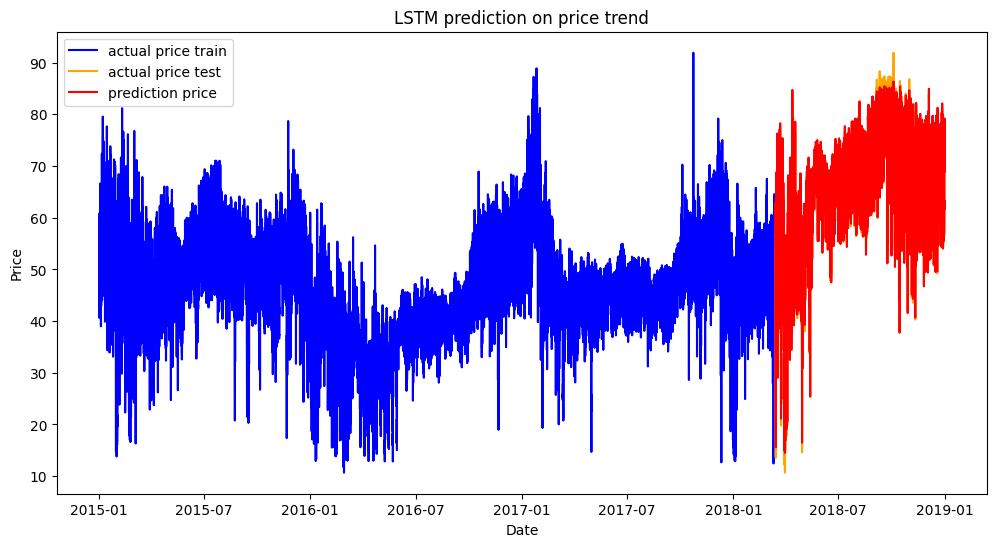

LSTM Root Mean Square Error: 2.6900784648847833
LSTM Mean Squared Error: 1.8852210406963306
LSTM R2 score:0.9460624482037443


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(X_train.index, y1_train, label='actual price train', color='blue')
plt.plot(X_test.index, y1_test, label='actual price test', color='orange')
plt.plot(X_test.index, lstm_pred1, label='prediction price', color='red')
plt.title('LSTM prediction on price trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#evaluate metrics
Lstm_RMSE = np.sqrt(mean_squared_error(y1_test, lstm_pred1))
Lstm_MAE = mean_absolute_error(y1_test, lstm_pred1)
Lstm_R2 = r2_score(y1_test, lstm_pred1)

print(f"LSTM Root Mean Square Error: {Lstm_RMSE}")
print(f"LSTM Mean Squared Error: {Lstm_MAE}")
print(f"LSTM R2 score:{Lstm_R2}")

Optuna tuning

In [ ]:
#data split
def prepare_data(n_steps):
    X = energy_pd_clean[feature_cols].values
    y = energy_pd_clean['price actual'].values

    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    # Train-test split (e.g., 80-20)
    split_idx = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
    X_val, y_val = X_seq[split_idx:], y_seq[split_idx:]

    return X_train, y_train, X_val, y_val

In [ ]:
def objective(trial):
    # Hyperparameters to tune
    n_units = trial.suggest_int('n_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    n_steps = trial.suggest_int('n_steps', 10, 50)

    # Prepare your data (replace with your actual preprocessing)
    X_train, y_train , X_val , y_val = prepare_data(n_steps)

    # Build the model
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(X_train.shape[1],  X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Evaluate performance
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)


[I 2025-07-29 00:03:35,938] A new study created in memory with name: no-name-f9fd2d28-583b-4ed8-965f-c1f80315a23a
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-07-29 00:06:32,198] Trial 0 finished with value: 4.414005713377969 and parameters: {'n_units': 57, 'dropout_rate': 0.20301010944323059, 'learning_rate': 0.0019388833253742236, 'n_steps': 13}. Best is trial 0 with value: 4.414005713377969.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2025-07-29 00:18:57,653] Trial 1 finished with value: 3.5276203639319093 and parameters: {'n_units': 100, 'dropout_rate': 0.24087122851824982, 'learning_rate': 0.001468326038650038, 'n_steps': 46}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2025-07-29 00:30:36,992] Trial 2 finished with value: 3.7081109257358276 and parameters: {'n_units': 86, 'dropout_rate': 0.34611922868583256, 'learning_rate': 0.0003714184123925233, 'n_steps': 47}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-07-29 00:36:16,037] Trial 3 finished with value: 4.126344279121431 and parameters: {'n_units': 112, 'dropout_rate': 0.27989951955094705, 'learning_rate': 0.0008369622880386566, 'n_steps': 14}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


[I 2025-07-29 00:49:47,425] Trial 4 finished with value: 4.137445033261438 and parameters: {'n_units': 125, 'dropout_rate': 0.17927999018045468, 'learning_rate': 0.0035915816977133827, 'n_steps': 39}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


[I 2025-07-29 00:55:30,635] Trial 5 finished with value: 4.146946920638329 and parameters: {'n_units': 57, 'dropout_rate': 0.10667587758591052, 'learning_rate': 0.000495039658478621, 'n_steps': 38}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-07-29 01:02:16,028] Trial 6 finished with value: 4.546668149800287 and parameters: {'n_units': 53, 'dropout_rate': 0.10608337217264836, 'learning_rate': 0.004588984745856658, 'n_steps': 50}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


[I 2025-07-29 01:15:23,426] Trial 7 finished with value: 3.9249166336822405 and parameters: {'n_units': 128, 'dropout_rate': 0.4284447431780317, 'learning_rate': 0.0009203279758342826, 'n_steps': 34}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-07-29 01:21:11,662] Trial 8 finished with value: 3.865807812621902 and parameters: {'n_units': 45, 'dropout_rate': 0.20531216552947493, 'learning_rate': 0.00038828663166901565, 'n_steps': 38}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


[I 2025-07-29 01:34:12,502] Trial 9 finished with value: 3.618488960296787 and parameters: {'n_units': 99, 'dropout_rate': 0.3893707126860133, 'learning_rate': 0.00013402591969038227, 'n_steps': 49}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-07-29 01:40:15,108] Trial 10 finished with value: 5.735695751154554 and parameters: {'n_units': 78, 'dropout_rate': 0.487947758814668, 'learning_rate': 0.008954280340992007, 'n_steps': 22}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2025-07-29 01:52:31,074] Trial 11 finished with value: 3.7361965926429215 and parameters: {'n_units': 99, 'dropout_rate': 0.3389156100823295, 'learning_rate': 0.00012273460038965487, 'n_steps': 44}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


[I 2025-07-29 01:59:08,366] Trial 12 finished with value: 3.6388446177637173 and parameters: {'n_units': 93, 'dropout_rate': 0.4057500312893866, 'learning_rate': 0.0001273642548940119, 'n_steps': 28}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2025-07-29 02:12:20,768] Trial 13 finished with value: 4.2758887147348075 and parameters: {'n_units': 105, 'dropout_rate': 0.26544657939462807, 'learning_rate': 0.0017564274327774502, 'n_steps': 44}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-07-29 02:23:14,532] Trial 14 finished with value: 3.6429304735235535 and parameters: {'n_units': 73, 'dropout_rate': 0.39526277878193505, 'learning_rate': 0.00023794514105908364, 'n_steps': 50}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


[I 2025-07-29 02:35:17,637] Trial 15 finished with value: 3.573659810791448 and parameters: {'n_units': 117, 'dropout_rate': 0.3285543924165273, 'learning_rate': 0.0016232991682844727, 'n_steps': 26}. Best is trial 1 with value: 3.5276203639319093.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-07-29 02:48:07,895] Trial 16 finished with value: 3.4643907710495947 and parameters: {'n_units': 115, 'dropout_rate': 0.24044204495610533, 'learning_rate': 0.0021067934729703786, 'n_steps': 26}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


[I 2025-07-29 02:54:45,201] Trial 17 finished with value: 3.942129159964885 and parameters: {'n_units': 113, 'dropout_rate': 0.22783366558328877, 'learning_rate': 0.0029469382804326472, 'n_steps': 19}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-07-29 02:58:55,869] Trial 18 finished with value: 6.048578554060422 and parameters: {'n_units': 33, 'dropout_rate': 0.24923866856707683, 'learning_rate': 0.006491315145648537, 'n_steps': 33}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-07-29 03:04:06,431] Trial 19 finished with value: 3.59172726310013 and parameters: {'n_units': 68, 'dropout_rate': 0.15746261227811162, 'learning_rate': 0.0011776401095866288, 'n_steps': 25}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-07-29 03:08:12,211] Trial 20 finished with value: 3.5454611272699825 and parameters: {'n_units': 83, 'dropout_rate': 0.3056467018862982, 'learning_rate': 0.0006481666993793038, 'n_steps': 18}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-07-29 03:11:25,107] Trial 21 finished with value: 3.5877001144317204 and parameters: {'n_units': 84, 'dropout_rate': 0.3023980372354709, 'learning_rate': 0.0005929817529534826, 'n_steps': 19}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-07-29 03:14:16,451] Trial 22 finished with value: 5.857489859215292 and parameters: {'n_units': 92, 'dropout_rate': 0.30488505431321766, 'learning_rate': 0.0024240500710312066, 'n_steps': 10}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2025-07-29 03:20:19,699] Trial 23 finished with value: 3.744142682738049 and parameters: {'n_units': 105, 'dropout_rate': 0.1564408600793442, 'learning_rate': 0.0012587000125823908, 'n_steps': 21}. Best is trial 16 with value: 3.4643907710495947.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


[I 2025-07-29 03:32:48,541] Trial 24 finished with value: 3.9729082866794307 and parameters: {'n_units': 119, 'dropout_rate': 0.24207884651592465, 'learning_rate': 0.0007331078474647733, 'n_steps': 32}. Best is trial 16 with value: 3.4643907710495947.


Best RMSE: 3.4643907710495947
Best hyperparameters: {'n_units': 115, 'dropout_rate': 0.24044204495610533, 'learning_rate': 0.0021067934729703786, 'n_steps': 26}


In [ ]:
study.best_params

{'n_units': 115,
 'dropout_rate': 0.24044204495610533,
 'learning_rate': 0.0021067934729703786,
 'n_steps': 26}

In [ ]:
study.best_value

3.4643907710495947

In [ ]:
#optimization visualization
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [ ]:
def normalize_func(data):
  scaler = MinMaxScaler()
  return scaler.fit_transform(data)
def reverse_func(data):
  return scaler.inverse_transform(data)

In [ ]:
#Fine tuned output
#build LSTM model
learning_rate =  0.0021067934729703786
n_steps = 26
n_units = 115
dropout_rate = 0.24044204495610533
X_train_opt ,y_train_opt, X_val_opt, y_val_opt = prepare_data(n_steps)
#reshape
X_train_2d = X_train_opt.reshape(-1,X_train_opt.shape[2])
X_val_2d = X_val_opt.reshape(-1,X_val_opt.shape[2])
#apply MinMaxScaler
X_train_scaled = normalize_func(X_train_2d)
X_val_scaled = normalize_func(X_val_2d)
y_train_scaled = normalize_func(y_train_opt.reshape(-1,1))
y_val_scaled = normalize_func(y_val_opt.reshape(-1,1))
#Reshape back to 3D
X_train_opt1 = X_train_scaled.reshape(-1, n_steps, X_train_opt.shape[2])
X_val_opt1 = X_val_scaled.reshape(-1, n_steps, X_val_opt.shape[2])
start_time = time.time()
model= Sequential()
model.add(LSTM(n_units, activation='relu', input_shape=(X_train_opt.shape[1],X_train_opt.shape[2])))
model.add(Dropout(dropout_rate))
model.add(Dense(1))
model.compile(optimizer= Adam(learning_rate=learning_rate),loss='mse')
model.fit(X_train_opt,y_train_scaled, epochs=20, batch_size=32, verbose=1)
end_time = time.time()

LSTMoptdelta_time = end_time - start_time
print(f"Time taken: {LSTMoptdelta_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 7908.7588
Epoch 2/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 24.3041
Epoch 3/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 6.7246
Epoch 4/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 4.9603
Epoch 5/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - loss: 3.1811
Epoch 6/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 1.6749
Epoch 7/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.6609
Epoch 8/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.1776
Epoch 9/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.0500
Epoch 10/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0212
Epoch 11/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0173
Epoch 12/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.0196
Epoch 13/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0183
Epoch 14/20
876/876 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0205
Epoch 15/20
876/876 ━━━━━

In [ ]:
lstm_pred_opt = model.predict(X_val_opt)

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


In [ ]:
#revert the MinMaxScale back to original
X_train_unscaled = X_train_opt.reshape(-1, X_train_opt.shape[2])
X_val_unscaled = X_val_opt.reshape(-1, X_val_opt.shape[2])

lstm_pred_opt = reverse_func(lstm_pred_opt)
y_val_opt = reverse_func(y_val_scaled)
y_train_opt = reverse_func(y_train_scaled)
X_train_opt = reverse_func(X_train_unscaled)
X_val_opt = reverse_func(X_val_unscaled)

In [ ]:
X_train_index = X
first_range=(len(X_train_index)-len(lstm_pred_opt))
X_train_ind, X_test_ind = X_train_index[:int(first_range)], X_train_index[int(first_range):]

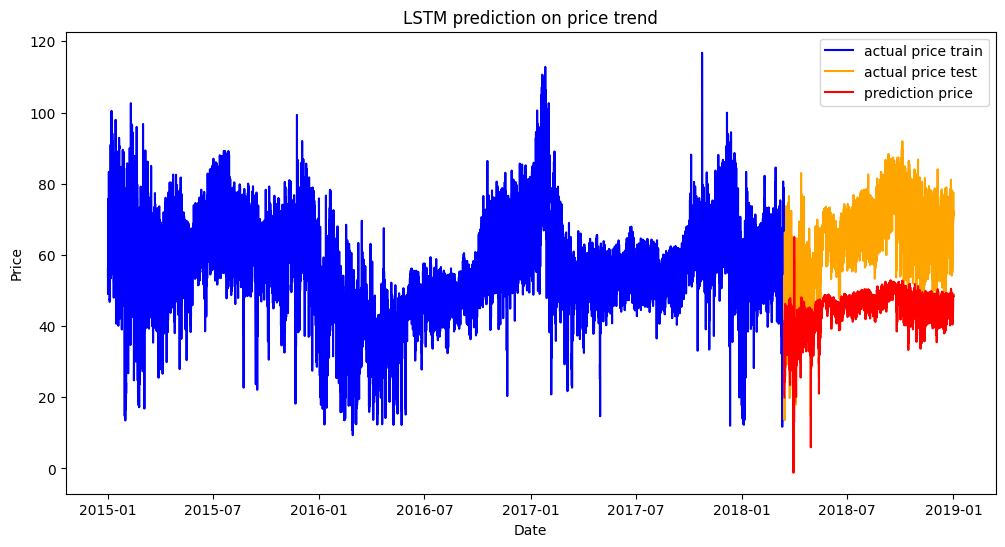

LSTM_opt Root Mean Square Error: 21.210859542207178
LSTM_opt Mean Squared Error: 19.970950577738996
LSTM_opt R2 score:-2.3610777340346627


In [ ]:
plt.figure(figsize=(12,6))
plt.plot(X_train.index,y_train, label='actual price train', color='blue')
plt.plot(X_test_ind.index, y_val_opt, label='actual price test', color='orange')
plt.plot(X_test_ind.index,lstm_pred_opt, label='prediction price', color='red')
plt.title('LSTM prediction on price trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#evaluate metrics
Lstm_opt_RMSE = np.sqrt(mean_squared_error(y_val_opt, lstm_pred_opt))
Lstm_opt_MAE = mean_absolute_error(y_val_opt, lstm_pred_opt)
Lstm_opt_R2 = r2_score(y_val_opt, lstm_pred_opt)



print(f"LSTM_opt Root Mean Square Error: {Lstm_opt_RMSE}")
print(f"LSTM_opt Mean Squared Error: {Lstm_opt_MAE}")
print(f"LSTM_opt R2 score:{Lstm_opt_R2}")


#Temporal Fusion Transformer

In [ ]:
from neuralforecast.models import TFT
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE

In [ ]:
tdf = energy_pd_clean.reset_index().rename(columns={'time':'ds', 'price actual':'y'})
tdf['unique_id'] ='series_1'


In [ ]:
tdf.columns

Index(['ds', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind offshore eday ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'y', 'price_actual_lag_1',
       'price_actual_lag_2', 'price_actual_lag_3', 'price_actual_lag_4',
       'rolling_mean_3', 'rolling_std_3', 'unique_id'],
      dtype='object')

In [ ]:
split_ratio = len(tdf)*0.8

In [ ]:
tdf_train=tdf.iloc[:int(split_ratio)]
tdf_test=tdf.iloc[int(split_ratio):]

In [ ]:
start_time = time.time()
model = TFT(
    h=24,
    input_size=168,
    max_steps=100,
    learning_rate=1e-3,
    hidden_size=64,
    dropout=0.1,
    loss=MAE(),
    scaler_type='robust',
    futr_exog_list=['total load forecast'],
    hist_exog_list=['price_actual_lag_1', 'rolling_mean_3']

    )

nf = NeuralForecast(models=[model], freq='H')
nf.fit(df=tdf_train)
end_time = time.time()
TFTdelt_time = end_time-start_time
print(f"Time taken: {TFTdelt_time:.2f} seconds")

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 197 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


Time taken: 1783.11 seconds


In [ ]:
transformer_features = ['unique_id', 'ds', 'total load forecast']
ytdf = pd.DataFrame()
for feature in transformer_features:
  ytdf[feature] = tdf_test[feature]
ytdf

,unique_id,ds,total load forecast
28048,series_1,2018-03-14 19:00:00+00:00,35748.0
28049,series_1,2018-03-14 20:00:00+00:00,34803.0
28050,series_1,2018-03-14 21:00:00+00:00,32321.0
28051,series_1,2018-03-14 22:00:00+00:00,29373.0
28052,series_1,2018-03-14 23:00:00+00:00,27637.0
...,...,...,...
35055,series_1,2018-12-31 18:00:00+00:00,30619.0
35056,series_1,2018-12-31 19:00:00+00:00,29932.0
35057,series_1,2018-12-31 20:00:00+00:00,27903.0
35058,series_1,2018-12-31 21:00:00+00:00,25450.0


In [ ]:
forecast_df = nf.predict(futr_df=ytdf)

/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/neuralforecast/core.py:940: UserWarning: Dropped 6,988 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast_df

,unique_id,ds,TFT
0,series_1,2018-03-14 19:00:00+00:00,49.977047
1,series_1,2018-03-14 20:00:00+00:00,48.206051
2,series_1,2018-03-14 21:00:00+00:00,42.655758
3,series_1,2018-03-14 22:00:00+00:00,36.212936
4,series_1,2018-03-14 23:00:00+00:00,29.729330
5,series_1,2018-03-15 00:00:00+00:00,24.133675
6,series_1,2018-03-15 01:00:00+00:00,22.128410
7,series_1,2018-03-15 02:00:00+00:00,21.861656
8,series_1,2018-03-15 03:00:00+00:00,22.433882
9,series_1,2018-03-15 04:00:00+00:00,23.957184


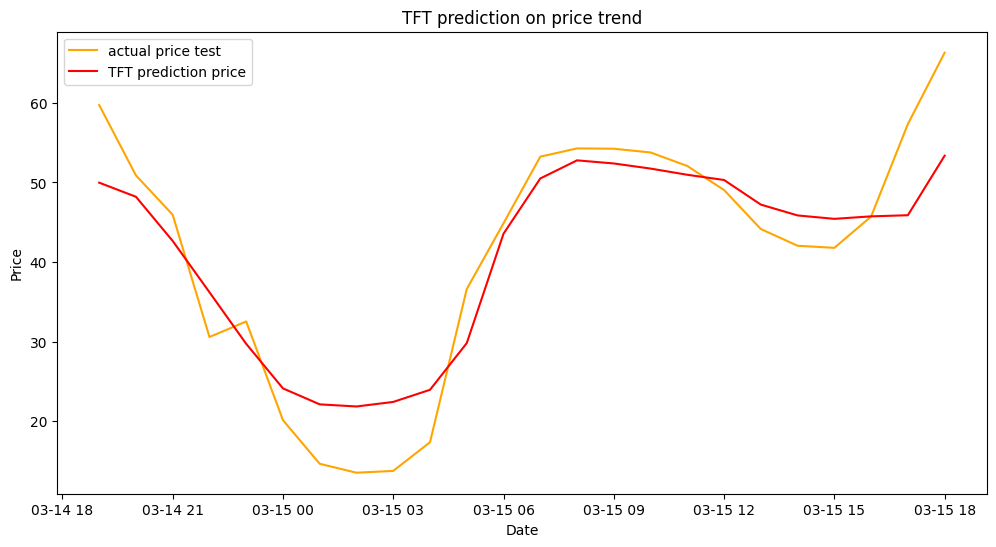

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(tdf_train['ds'], tdf_train['y'], label='actual price train', color='blue')
plt.plot(tdf_test['ds'][:24], tdf_test['y'][:24], label='actual price test', color='orange')
plt.plot(forecast_df['ds'], forecast_df['TFT'], label='TFT prediction price', color='red')
plt.title('TFT prediction on price trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

##Cross-validation->TFT

In [ ]:
cv_df= nf.cross_validation(n_windows=5, df=tdf)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 197 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
----------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
cv_df

,unique_id,ds,cutoff,TFT,y
0,series_1,2018-12-30 19:00:00+00:00,2018-12-30 18:00:00+00:00,73.194374,73.35
1,series_1,2018-12-30 20:00:00+00:00,2018-12-30 18:00:00+00:00,72.928352,73.64
2,series_1,2018-12-30 21:00:00+00:00,2018-12-30 18:00:00+00:00,71.583725,71.92
3,series_1,2018-12-30 22:00:00+00:00,2018-12-30 18:00:00+00:00,69.158966,69.49
4,series_1,2018-12-30 23:00:00+00:00,2018-12-30 18:00:00+00:00,66.197685,68.40
...,...,...,...,...,...
115,series_1,2018-12-31 18:00:00+00:00,2018-12-30 22:00:00+00:00,74.531204,77.02
116,series_1,2018-12-31 19:00:00+00:00,2018-12-30 22:00:00+00:00,73.941490,76.16
117,series_1,2018-12-31 20:00:00+00:00,2018-12-30 22:00:00+00:00,71.515442,74.30
118,series_1,2018-12-31 21:00:00+00:00,2018-12-30 22:00:00+00:00,69.070198,69.89


In [ ]:
#evaluation
TFT_RMSE = np.sqrt(mean_squared_error(cv_df['y'], cv_df['TFT']))
TFT_MAE = mean_absolute_error(cv_df['y'], cv_df['TFT'])
TFT_R2 = r2_score(cv_df['y'], cv_df['TFT'])

print(f"TFT_RMSE: {TFT_RMSE:.3f}")
print(f"TFT_MAE: {TFT_MAE:.3f}")
print(f"TFT_R2: {TFT_R2:.3f}")

TFT_RMSE: 2.905
TFT_MAE: 2.437
TFT_R2: 0.806


In [ ]:
#sort the correct datetime
cv_df_sorted=cv_df.sort_values(by='ds',ascending=True)

slice(34941, 35060, None)


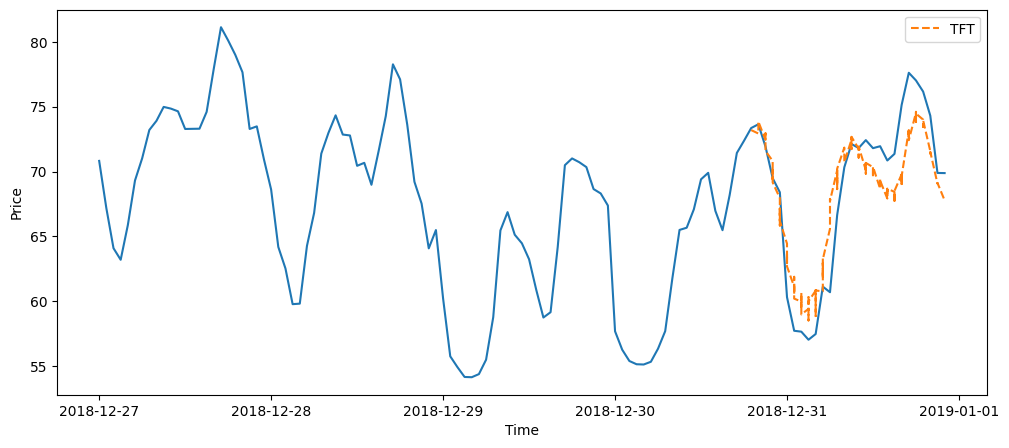

In [ ]:
#plot cross-validation result
cutoffs = cv_df['cutoff'].unique()


start_range=(len(tdf)-119)
display_range = slice(int(start_range),int(len(tdf)))
delt = len(tdf) - start_range
print(display_range)
plt.figure(figsize=(12,5))


plt.plot(tdf['ds'][display_range], tdf['y'][display_range])
plt.plot(cv_df_sorted['ds'], cv_df_sorted['TFT'], label='TFT', ls='--')

#for cutoff in cutoffs:
  #plt.axvline(x=cutoff, color='red', ls=':')

plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

the prediction result generated from TFT model shows a close trend to the original target feature, the movement trend are similar as well. Hence, the result is good.

Next, if look at the evaluation matrix we can observe that a low RMSE and MSE generate from the TFT model which with respect of 2.828 and 2.242. However, the R2 shows a fair low score compare to XG Boost which has the R2 score of 0.816.

the lower prediction power compare to XG boost might be consist with several reason, one might be due to value range from the input feature. furthermore, the future feature that used in this model might have less correlation, hence it affect model prediction performances. the future exogenous variable was used `total load forecast`, if more related future variable are added in the future exogenous variable which might able to improve the model prediction performance.

#Comparing all model result

In [ ]:
#compare all models evaluation matrix
F_evametrics = pd.DataFrame({
    'Model': ['Persistence', 'XGBRegressor', 'XGBRegressor (Optuna)','LSTM', 'LSTM {Optuna}', 'TFT'],
    'RMSE': [P_RMSE, XGB_RMSE, XGB2_RMSE, Lstm_RMSE, Lstm_opt_RMSE,TFT_RMSE],
    'MAE': [P_MSE, XGB_MAE, XGB2_MAE, Lstm_MAE, Lstm_opt_MAE,TFT_MAE],
    'R2': [P_R2, XGB_R2, XGB2_R2, Lstm_R2, Lstm_opt_R2, TFT_R2],
    'duration': [Pdelta_time, XGdelta_time, XGBdelt_time, LSTMdelta_time, LSTMoptdelta_time, TFTdelt_time],
    })
F_evametrics.set_index('Model', inplace=True)
F_evametrics=F_evametrics.style.set_caption("Model Evaluation Metrics").format("{:.5f}")
F_evametrics=F_evametrics.set_table_styles(
    [
        {'selector': 'th', 'props': [('text-align', 'left')]},
        {'selector': 'td', 'props':[('text-alight', 'left')]},
        {'selector': 'caption', 'props':[('font-size', '18px'),
                                         ('font-weight','bold')]}
    ]
)
F_evametrics


,RMSE,MAE,R2,duration
Model,,,,
Persistence,3.66068,13.40056,0.93358,0.01191
XGBRegressor,2.60401,1.81935,0.94946,0.24644
XGBRegressor (Optuna),2.56624,1.80295,0.94946,2.48322
LSTM,2.69008,1.88522,0.94606,84.00867
LSTM {Optuna},21.21086,19.97095,-2.36108,678.86769
TFT,2.90478,2.43727,0.80552,1783.11225


Based on the model evaluation Metrics, the outstanding model is optimized XGBregressor and LSTM which both have a 0.949 R2 and 0.946 R2. However, Optimized XGB Regreessor has 0.13 lower deviation compare to LSTM.

Furthermore, if we compare the duration optimized XGBRegressor has a lesser training duration compare to LSTM. this is due to different architecture of model. Where LSTM is a neural based model which has a different learning artichitecture compare to XGBoost.

Other than that, Temparol Fusion Transformer has the highest training duration with having a decent prediction capabilities. Since the model is training at 100 epoch, this there might be a possibilities of achieving better R2 result compare to now. TFT model has fairly less deviation which is 2.90478. although is 0.4 higher than optimized XGBoost and LSTM. But, is still able to present the prediction trend that have less differences from actual value.

<Figure size 1200x600 with 0 Axes>

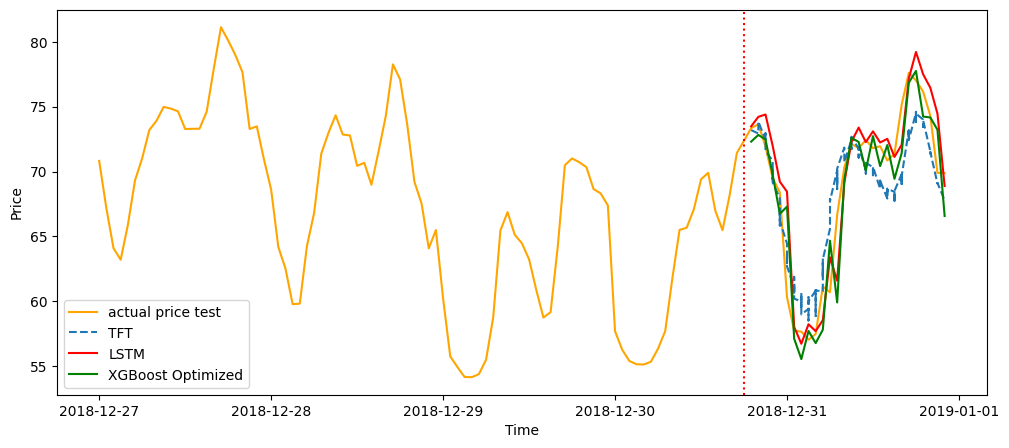

In [ ]:
cutoffs = cv_df['cutoff'].unique()

plt.figure(figsize=(12,6))

start_range=(len(tdf)-119)
display_range = slice(int(start_range),int(len(tdf)))
delt = len(tdf) - start_range
start_time = pd.Timestamp('2018-12-30 19:00:00', tz='UTC')
end_time = pd.Timestamp('2018-12-31 22:00:00', tz='UTC')

mask = (X_test.index >= start_time) & (X_test.index <= end_time)


plt.figure(figsize=(12,5))
plt.plot(tdf['ds'][display_range], tdf['y'][display_range], label='actual price test', color='orange')
plt.plot(cv_df_sorted['ds'], cv_df_sorted['TFT'], label='TFT', ls='--')
plt.plot(X_test.index[mask], lstm_pred1[mask],label='LSTM', color='red')
plt.plot(X_test.index[mask], XGB_pred_opt[mask], label='XGBoost Optimized', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.axvline(x=cutoffs[0], color='red', ls=':', label='cutoff')



From the graph, XGBoost optimized model prediction are closes to the actual price test data, follow by LSTM and lastly TFT. The 3 of the model are able to predict the similar trend pattern of the actual price.

due to less RMSE, most of the model prediction are close to actal price value, there is only less than 3 difference between them. furthermore, high R2_score presenting the prediction correction of the model. LSTM and XGboost Optimized has 0.94 R2 score, hence both of them their prediction are close to the actual price. TFT which has a decent R2 score which is 0.8, the prediction are slightly lower than the actual value at the end of the prediction or after approximate 6 hours.

#Summary & Conclusion
1. Key Results
the project presented different model with their evaluation result. From the metrics we can tell that XGBoost (optuna) is the top candidate among other model due to highest R2 score, shorter training time and lesser RMSE. Compare to LSTM, LSTM is second highest choices of selection based on the evaluation result. However, LSTM has a longer training time compare to XGBoost.

2. Observation & Insights

Performance vs Complexity:
```
 Deep learning model are more complex, XGBoost delivered nearly simialr accuracy with much faster training time. This indicate that XGBoost is more practical for real-tim industrial application.
```

Transformers' Advantages:
```
TFT captured temporal dependencies effectively and can handle future covariates, making it a suitable candidate for long-horizon forecasting tasks despite its higher computational cost.
```

Feature Importances:
```
Optuna tuning revealed that lag features and generation attributes had the highest impact on prediction accuracy.
```

3. Limitations

      -Limited hyperparameter tuning for LSTM and TFT due to resources constraints.

      -Weather data not included(could improve long-term forecasting)

      -Dataset lack of consumption information as feature input for model which this could possible improve the forecasting.

      -No real deployment or streaming pipeline yet.






#Download model

In [ ]:
#save XGBoost (optuna) trained model to local
import pickle
with open('/content/XGBModel.pkl', 'wb') as f:
  pickle.dump(XGBModel2, f)

#Feature engineering

In [ ]:
energy_pd_clean

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,total load forecast,total load actual,price day ahead,price actual,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,rolling_mean_3,rolling_std_3
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,383.51354,1826.0,953.0,720.0,7097.0,...,21785.0,20264.0,38.41,56.04,59.32,64.48,64.92,65.41,57.882727,2.501835
2015-01-01 04:00:00+00:00,410.0,178.0,4038.0,3590.0,156.0,383.51354,2109.0,952.0,743.0,7098.0,...,21441.0,19905.0,35.72,53.63,56.04,59.32,64.48,64.92,57.882727,2.501835
2015-01-01 05:00:00+00:00,401.0,172.0,4040.0,3368.0,158.0,383.51354,2108.0,961.0,848.0,7098.0,...,21285.0,20010.0,35.13,51.73,53.63,56.04,59.32,64.48,57.882727,2.501835
2015-01-01 06:00:00+00:00,408.0,172.0,4030.0,3208.0,160.0,383.51354,2031.0,983.0,1012.0,7099.0,...,21545.0,20377.0,36.22,51.43,51.73,53.63,56.04,59.32,53.800000,2.160023
2015-01-01 07:00:00+00:00,413.0,177.0,4052.0,3335.0,161.0,383.51354,2119.0,1001.0,1015.0,7098.0,...,21443.0,20094.0,32.40,48.98,51.43,51.73,53.63,56.04,52.263333,1.193035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,383.51354,1.0,1135.0,4836.0,6073.0,...,30619.0,30653.0,68.85,77.02,77.61,75.13,71.36,70.85,74.700000,3.147110
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,383.51354,1.0,1172.0,3931.0,6074.0,...,29932.0,29735.0,68.40,76.16,77.02,77.61,75.13,71.36,76.586667,1.295544
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,383.51354,50.0,1148.0,2831.0,6076.0,...,27903.0,28071.0,66.88,74.30,76.16,77.02,77.61,75.13,76.930000,0.729178


In [ ]:
energy_pd_clean.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind offshore eday ahead',
       'forecast wind onshore day ahead', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'price_actual_lag_1', 'price_actual_lag_2', 'price_actual_lag_3',
       'price_actual_lag_4', 'rolling_mean_3', 'rolling_std_3'],
      dtype='object')

In [ ]:
energy_pd_clean['days'] = energy_pd_clean.index.day
energy_pd_clean['weekdays'] = energy_pd_clean.index.weekday
energy_pd_clean['months'] = energy_pd_clean.index.month
energy_pd_clean['years'] = energy_pd_clean.index.year

In [ ]:
cat_y_m = energy_pd_clean.groupby(['years','months']).sum()

In [ ]:
cat_y_m=cat_y_m.reset_index()

In [ ]:
cat_y_m['dates'] = pd.to_datetime(cat_y_m[['years', 'months']].assign(day=1))

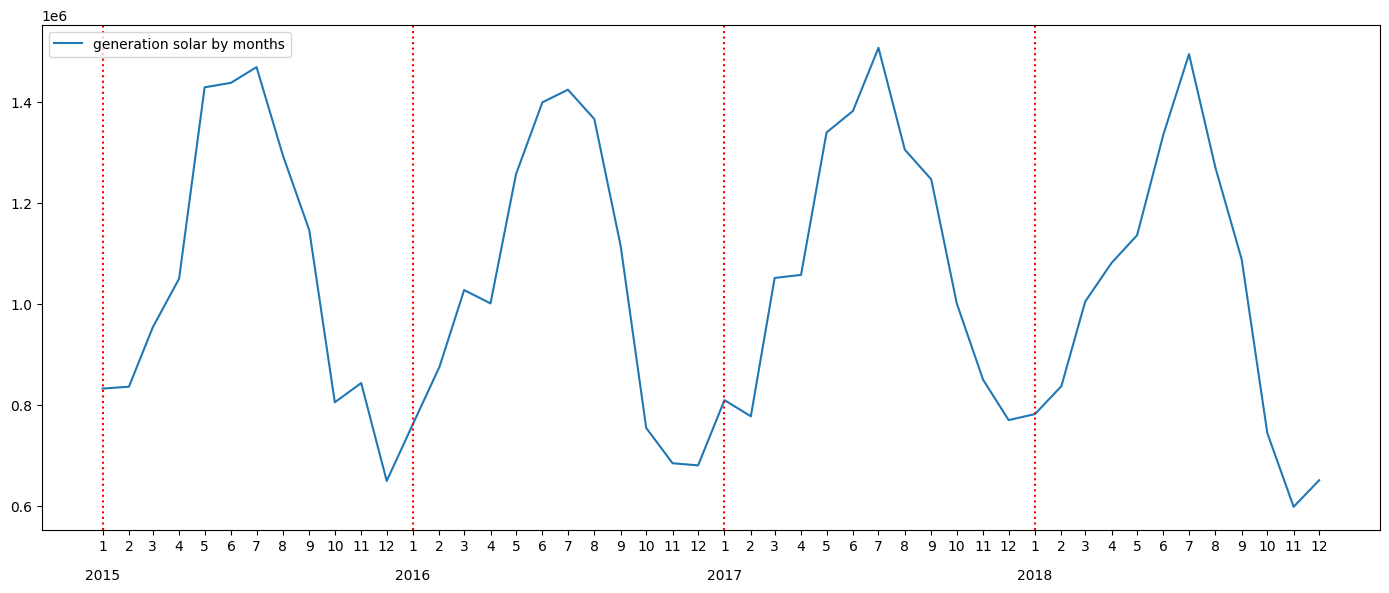

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(cat_y_m['dates'], cat_y_m['generation solar'], label='generation solar by months')
ax.set_xticks(cat_y_m['dates'])
ax.set_xticklabels(cat_y_m['months'])

#Only annotate January of each year
jan_mask = cat_y_m['months'] ==1
for i in cat_y_m[jan_mask].index:
  date = cat_y_m.loc[i, 'dates']
  year = cat_y_m.loc[i, 'years']
  ax.text(date, ax.get_ylim()[0]-ax.get_ylim()[1]*0.05 , str(year),
          ha ='center', va='top', fontsize=10)
  plt.axvline(x=date, color='r', ls=':')



plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
#download featured engineered dataset
energy_pd_clean.to_csv('/content/energy_pd_clean.csv')
cat_y_m.to_csv('/content/cat_y_m.csv')